In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt

# Pre-processing
- Resized to 224x224 pixels. This is because the ResNet-18 model was originally designed for ImageNet (which consists of 224x224 images).

- Converted to tensors, and their pixel values are scaled between [0, 1].

- Normalized with a mean and standard deviation of 0.5. This step is crucial to ensure that the values of the input tensor are roughly on the same scale. Typically, for full RGB images, the mean and std of the ImageNet dataset would be used, but for grayscale images like MNIST, a single channel value is provided.

In [ ]:
# Apply resize and normalization to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data Loading:

The code uses torchvision.datasets to load MNIST, a dataset of hand-written digits. The DataLoader constructs mini-batches automatically. These mini-batches are used in training and testing the model.

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 25669850.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 124625199.41it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1519229.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23147665.57it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Model Modification:

By default, ResNet-18 expects a 3-channel (RGB) image of size 224x224. MNIST images are 1-channel images of size 28x28. The following modifications are done:

- The first layer of ResNet-18 (model.conv1) is changed to accept a 1-channel input.

- The final layer (model.fc) has its out_features set to 10, because there are 10 classes in MNIST.

In [4]:
# Modify ResNet-18 for MNIST
model = resnet18(pretrained=False)
# Change the input layer to accept grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Adjust the final layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Moving to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Metrics Storage:

During both training and evaluation, the code computes and stores loss and accuracy for later visualization. This is done using the train_losses, train_accuracies, test_losses, and test_accuracies lists.

In [7]:
# Lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Loss Function and Optimizer:

CrossEntropyLoss: This is a common loss function used for classification tasks. It combines Softmax and Negative Log Likelihood loss.
Adam: It's an optimization algorithm that can handle sparse gradients on noisy problems.

# Training Loop:

This is where the bulk of the learning happens:

- model.train(): This tells the model that it's in training mode. This is essential because certain layers like dropout or batch normalization function differently during training and evaluation.

- optimizer.zero_grad(): Before the backward pass, the gradients are set to zero.

- outputs = model(inputs): Forward pass. It gets the predictions from the model for a batch of inputs.

- loss = criterion(outputs, labels): Compute the loss between the predictions and true labels.

- loss.backward(): Backward pass. Computes the gradient of the loss with respect to model parameters.

- optimizer.step(): Adjusts each parameter in accordance with its gradient.

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Epoch 1/10, Train Loss: 0.0189, Train Accuracy: 99.44%, Test Loss: 0.0249, Test Accuracy: 99.32%
Epoch 2/10, Train Loss: 0.0137, Train Accuracy: 99.60%, Test Loss: 0.0215, Test Accuracy: 99.42%
Epoch 3/10, Train Loss: 0.0189, Train Accuracy: 99.47%, Test Loss: 0.0282, Test Accuracy: 99.28%
Epoch 4/10, Train Loss: 0.0110, Train Accuracy: 99.70%, Test Loss: 0.0323, Test Accuracy: 99.15%
Epoch 5/10, Train Loss: 0.0112, Train Accuracy: 99.65%, Test Loss: 0.0226, Test Accuracy: 99.38%
Epoch 6/10, Train Loss: 0.0101, Train Accuracy: 99.67%, Test Loss: 0.0217, Test Accuracy: 99.46%
Epoch 7/10, Train Loss: 0.0114, Train Accuracy: 99.66%, Test Loss: 0.0291, Test Accuracy: 99.16%
Epoch 8/10, Train Loss: 0.0069, Train Accuracy: 99.78%, Test Loss: 0.0315, Test Accuracy: 99.30%
Epoch 9/10, Train Loss: 0.0095, Train Accuracy: 99.70%, Test Loss: 0.0280, Test Accuracy: 99.20%
Epoch 10/10, Train Loss: 0.0075, Train Accuracy: 99.78%, Test Loss: 0.0282, Test Accuracy: 99.25%


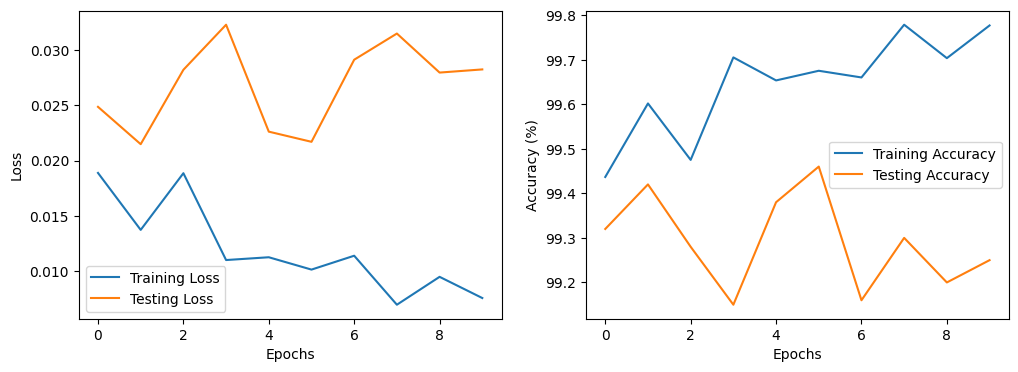

In [12]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

_ = plt.show()

# Evaluation Loop:

Here, the performance of the model is evaluated:

- model.eval(): Switches the model to evaluation mode.

Since we're only evaluating the model, we use torch.no_grad(). This is because we don't need to compute gradients, which saves memory and computation.
The rest of the loop is similar to the training loop, but without the backpropagation and optimization steps.

In [11]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

Accuracy of the model on the 10000 test images: 99.25%
